In [217]:
!which python

/Users/alexey/Documents/projects/swedish_privacy_mind/private_swedish_mind/private_mind/bin/python


In [218]:
import geopandas as gpd
import contextily as ctx
from shapely.ops import unary_union
import pandas as pd
from shapely.geometry import Point
from geovoronoi import voronoi_regions_from_coords, points_to_coords

import matplotlib.pyplot  as plt
import numpy as np

import os
import collections



In [219]:
SOURCE_EPSG = 4326
WGS84_EPSG  = 3857
SWEREF_EPSG =  3006

G3_ANTENNAS_PATH = "antennas/UMTS.CSV.gz"
G4_ANTENNAS_PATH = "antennas/LTE.CSV.gz"

SWEREF_EPSG_uppsala =  (647742, 6638924.00)

pd.set_option('display.max_colwidth', None)

SVERIGE_CONTOUR = 'sverige_contour/sverige.shp'
ALLA_KOMMUNER  = 'alla_kommuner/alla_kommuner.shp'

# dates  = ["2019-05-23", "2019-05-26", "2019-06-12", "2019-06-22", "2018-10-26_2018-10-27",
#          "2018-05-23_2018-05-24", "2017-11-20_2017-11-21", "2021-01-16_2021-01-15"]

DATA_DIR = 'data'

# dates = ["2017-11-20_2017-11-21",
# "2018-05-23_2018-05-24",
# "2018-10-26_2018-10-27",
# "2019-05-23",
# "2019-05-26",
# "2019-06-12",
# "2019-06-22",
# "2020-11-15",
# "2020-12-29_2020-12-30",
# "2021-01-16_2021-01-15",
# "2021-04-11"]


geometry_gps_csv = 'geometry_gps_csv'
geometry_mpn_csv = 'geometry_mpn_csv'
SE_SHAPEFILES = 'se_shapefiles/se_1km.shp'


In [220]:
def prepare_antennas():
    """
    reads and prepares antennas.
    Returns a GeoPandas df with the antennas.
    """

    try:
        g3 = pd.read_csv(G3_ANTENNAS_PATH, sep=';')[['llat', 'llong']]
        g4 = pd.read_csv(G4_ANTENNAS_PATH, sep=';')[['llat', 'llong']]

        antennas = pd.concat([g3,g4]).drop_duplicates().round(3)


        antennas_gdp = gpd.GeoDataFrame(antennas, geometry=gpd.points_from_xy(antennas.llong, antennas.llat), 
                                        crs=SOURCE_EPSG)[['geometry']]\
        .to_crs(SWEREF_EPSG)

        return antennas_gdp
    except:
        print("something is wrong with the antennas files")
        
        return None


In [221]:
def find_area(point):
    """
    given a point  within the area find that area in the table
    Returns geoPandas DF with the geometry
    """

    try:
        sweden = gpd.read_file(ALLA_KOMMUNER)
        sweden.crs=SWEREF_EPSG
    except:
        print('failed to read %s'% ALLA_KOMMUNER)
    
    uppsala = Point(point)

    uppsala_lan = None
    for index, row in sweden.iterrows():
        if uppsala.within(sweden.iloc[index].geometry):
            uppsala_lan = sweden.iloc[index:index+1].reset_index()

    if not uppsala_lan.empty:
        return uppsala_lan
    else:
        print('failed to find point %s in %s'%(point, ALLA_KOMMUNER))
    


In [222]:
def get_objects_within_area(antennas, area, geom='geometry'):
    """
    given antennas and bounding geometry find which antennas are within the geometry
    Returns a GeoPandas DF
    """
    if antennas.crs == area.crs:
        antennas_within = []
        for i, row in antennas.iterrows():
            if row[geom].within(area.geometry[0]):
                antennas_within.append(row)

        if antennas_within:
            antennas_within = gpd.GeoDataFrame(antennas_within, geometry=geom, crs=antennas.crs).reset_index()
        else:
            print("no antennas found within area")
         

        return antennas_within
    else:
        print('Objects have different CRSs')
        return None

In [223]:
def create_voronoi_polygons(antennas, bounding_geometry):
    """
    creates Voronoi polygons with antennas as centers, bounded by `bounding_geometry`
    
    """
    coords = points_to_coords(antennas.geometry)

    poly_shapes, pts = voronoi_regions_from_coords(coords, bounding_geometry.geometry[0])

    voronoi_polygons = gpd.GeoDataFrame({'geometry': poly_shapes}, crs=SWEREF_EPSG)
    
    return voronoi_polygons

In [224]:
def get_rings_around_cell(cell_idx, vcs, width):
    """
    given the Voronoi cells `vcs`, the index of the cell `cell_idx` and the number of 
    layers `width`
    creates a list of lists, where the first list contains indexes  of `vcs` for the zero layer,
    the second -- for the first layer etc.
    """

    result = [vcs.iloc[cell_idx:cell_idx+1]]
    t = [[cell_idx]]
    neighbours_dis = result[0].iloc[0].geometry
    for layer in range(width):
        
        neighbours = vcs[vcs.geometry.touches(neighbours_dis)]
        t.append(neighbours.index.to_list())
        result.append(neighbours)
        neighbours = pd.concat(result)
        neighbours_dis = unary_union(neighbours.geometry)

    return t

In [225]:
def make_hist_mpn_geoms(mpn_geoms, cell_rings):
    """
    taking list of `mpn_geoms` and corresponding list of cell rings `cell_rings`.
    Makes histogram for polulation of cell rings based in `mpn_geoms`.
    
    
    """
    
    hist = []
    for idx, ring in enumerate(cell_rings):
        for geom in mpn_geoms:
            if (geom in ring):
                hist.append(idx)
    return hist



In [226]:
def add_vcs_indexes(df, vcs):
    """
    Adding indexes of Voronoi cell from `vcs` for GPS and MPN points for given `df`
    """
    
    if df.crs == vcs.crs:


        vc_gps_points = []
        vc_mpn_points = []


    #     temp = vcs.to_crs(WGS84_EPSG).geometry
        temp = vcs.geometry


        for point in df.geometry_gps_csv:
            for i, vc  in enumerate(temp):
                if (point.within(vc)): vc_gps_points.append(i)

        for points in df.geometry_mpn_csv:
            t = []
            for point in points:
                for i, vc  in enumerate(temp):
                    if (point.within(vc)): t.append(i)
            vc_mpn_points.append(t)

        df['vc_index_gps'] = vc_gps_points
        df['vc_index_mpn'] = vc_mpn_points

        return df
    else:
        print('Objects have different CRSs')
        return None

In [227]:
def read_data(DATA_DIR):
    """
    reading data for given dates
    """
#     paths = ['data/result'+date+'.csv' for date in dates]
    paths = sorted([os.path.join(DATA_DIR,f) for f in os.listdir(DATA_DIR) if f.startswith('result')])
    
    
    
    dfs = []

    for path in paths:
        try:
            tmp = pd.read_csv(path, parse_dates= ['timestamp'])[['timestamp', 'geometry_gps_csv', 'geometry_mpn_csv']]
            print(tmp.shape[0], path)
    #         tmp = tmp.drop_duplicates(subset=['geometry_gps_csv'])
    #         print(tmp.shape[0], path)
            dfs.append(tmp)
        except:
            print('path %s is wrong. check it.' %path)
            pass

    read_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    return read_df


In [228]:
def process_df(df_):
    
    
    df_ = df_.groupby('timestamp').agg({geometry_gps_csv: "first", geometry_mpn_csv: list})
  
    df_ = df_.drop_duplicates(subset=['geometry_gps_csv'])
    
    df_[geometry_gps_csv] = df_[geometry_gps_csv].apply(
    lambda lst: Point(float(lst[1:-1].split(',')[0]), 
                      float(lst[1:-1].split(',')[1]))
    )
    
    df_[geometry_mpn_csv] = df_[geometry_mpn_csv].apply(
        lambda lst: [Point(float(item[1:-1].split(',')[0]), 
                          float(item[1:-1].split(',')[1])) for item in lst]
    )
    

    df_ = gpd.GeoDataFrame(df_, geometry=geometry_gps_csv, crs=WGS84_EPSG)#.to_crs(SWEREF_EPSG)


    return df_

In [229]:
def get_vcs_for_bounding_area(antennas, bounding_shape):
    """
    returns Voronoi cells and their centers 
    """
    if  bounding_shape.crs == antennas.crs: 
        antennas_within = get_objects_within_area(antennas, bounding_shape)
        print(antennas_within.crs, bounding_shape.crs)
        voronoi_polygons = create_voronoi_polygons(antennas_within, bounding_shape)


        return antennas_within, voronoi_polygons
    else:
        print("objects have differrent CRSs....")
        return None,None
    

In [230]:
def get_bounding_area(point=None):
    """
    returns bounding area.
    It could be either the whole Sweden, or it's Lan. In the last case one  need to provide a point within that lan in 
    Sweref99 format.
    
    """
    if point:
        contour = find_area(point)
    else:
        contour = gpd.read_file(SVERIGE_CONTOUR)
        contour.crs = WGS84_EPSG
        contour.to_crs(SWEREF_EPSG, inplace=True)
        
    return contour

        

# creating a countour file for sweden if needed

In [231]:
if not os.path.isfile(SVERIGE_CONTOUR):
    print(SVERIGE_CONTOUR +" does  not exist... creating")
    t = gpd.read_file(SE_SHAPEFILES)
    t.to_crs(WGS84_EPSG, inplace=True)
    g = t.geometry.unary_union
    gpd.GeoDataFrame(geometry=gpd.GeoSeries(g)).to_file(SVERIGE_CONTOUR)

In [232]:
antennas_gdp = prepare_antennas()

In [17]:
# test_polys = [res[1].geometry.iloc[0], 
#               res[1].geometry.iloc[3],
#               res[3].geometry.iloc[6]
#              ]

# make_hist_mpn_geoms(test_polys, res)

In [18]:
def _make_sample_ring_plot():
    
    uppsala_lan = get_bounding_area(point = SWEREF_EPSG_uppsala)
    antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, uppsala_lan)
    random_cell = voronoi_polygons.sample(1).index[0] #reset_index()
    res = get_rings_around_cell(random_cell, voronoi_polygons, 5)


    ax = uppsala_lan.to_crs(WGS84_EPSG).plot(figsize = (30,30), facecolor='none')
    antennas_within.to_crs(WGS84_EPSG).plot(ax=ax)
    voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax, facecolor='none')


    colors = ['blue', 'green', 'cyan', 'red', 'black', 'yellow']

    for l, color in zip(res, colors):
        voronoi_polygons.iloc[l].to_crs(WGS84_EPSG).plot(ax=ax, color=color, alpha=.5)

    ctx.add_basemap(ax=ax, zoom=10)
    plt.title("Uppsala lan, Voronoi cell rings")


    plt.savefig('../docs/pics/upp_vor_cell.png',bbox_inches = "tight")

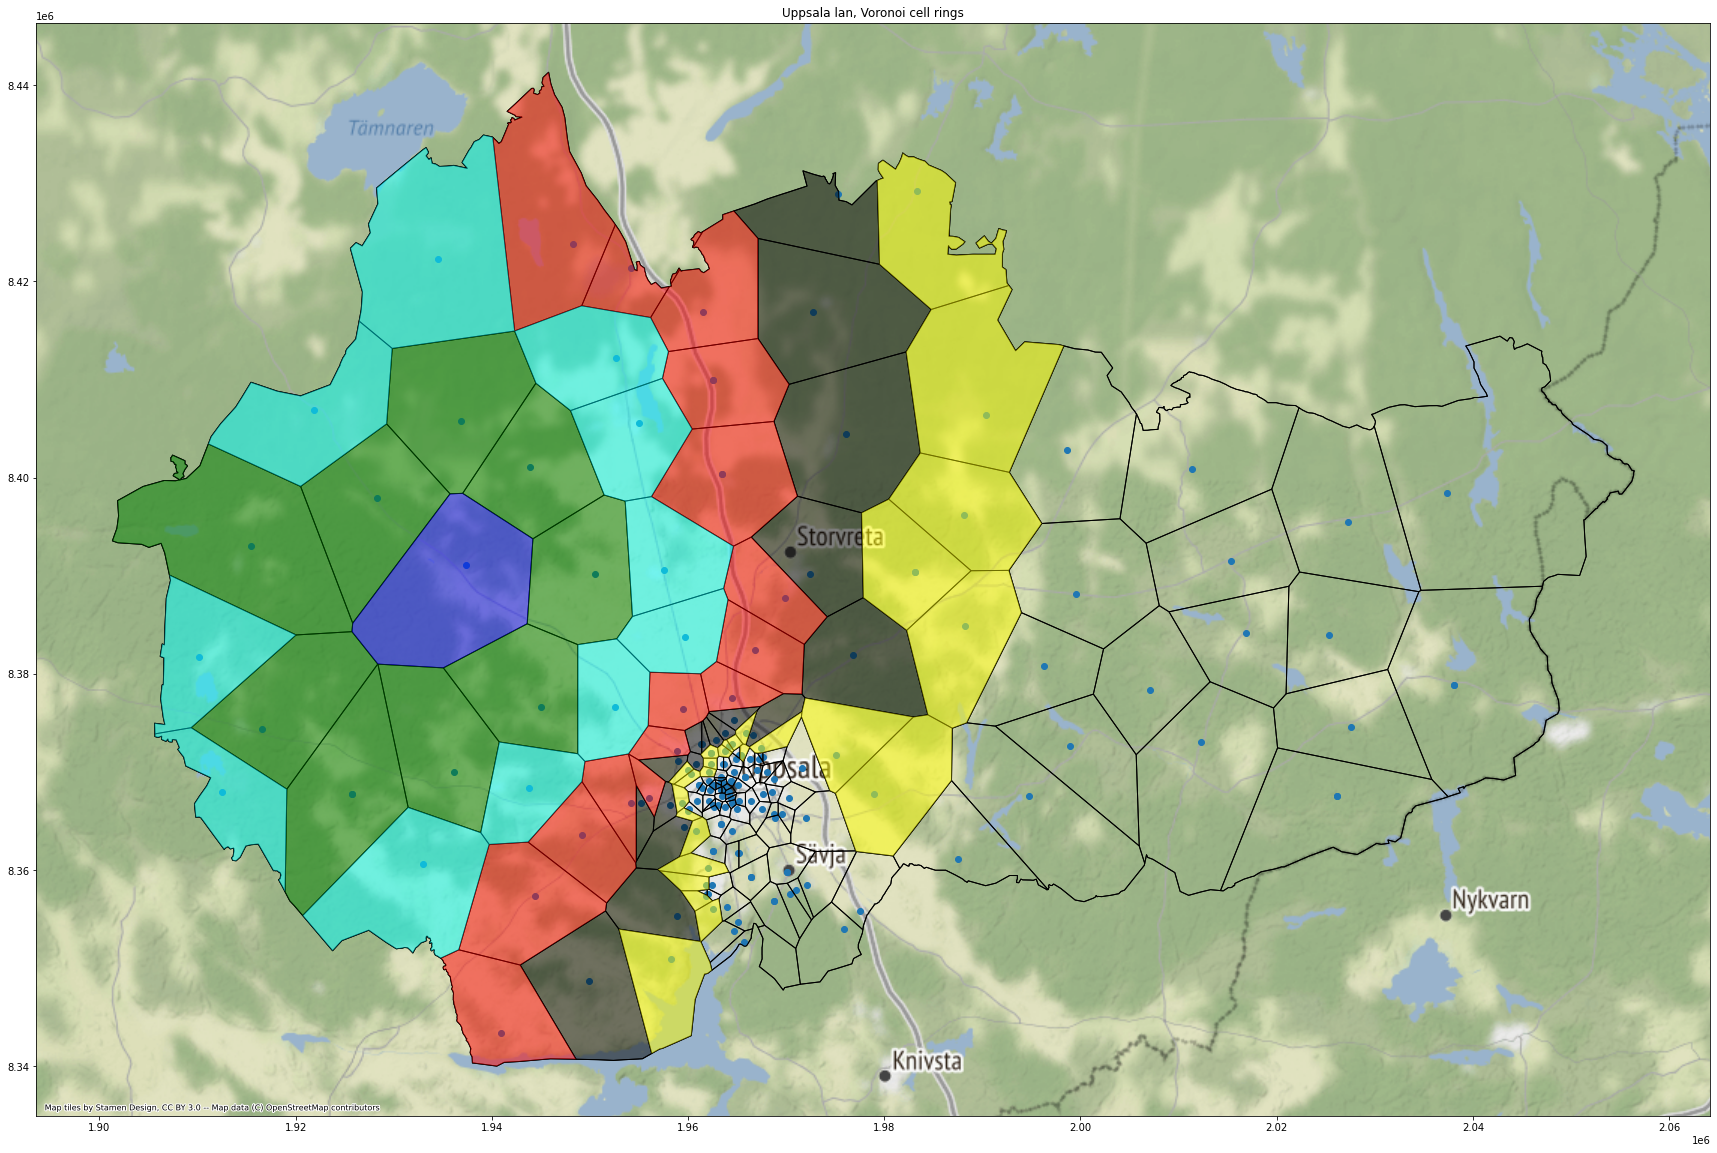

In [19]:
_make_sample_ring_plot()

In [20]:
!ls

Untitled.ipynb          cli.py                  rings.py
__init__.py             data                    se_shapefiles
__pycache__             hist.png                sverige_contour
alla_kommuner           marina_tracks.ipynb     track_within_shape.png
antennas                private_swedish_mind.py upp_vor_cell.png


In [211]:
sweden = get_bounding_area()
uppsala_lan = get_bounding_area(point = SWEREF_EPSG_uppsala)


In [212]:
antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, sweden)

epsg:3006 epsg:3006


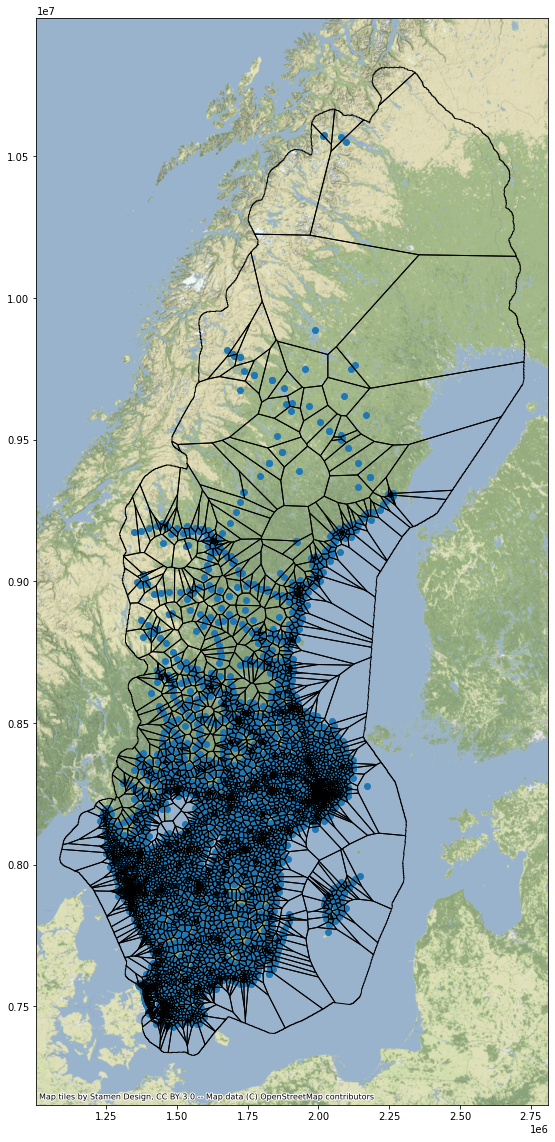

In [365]:
ax = antennas_within.to_crs(WGS84_EPSG).plot(figsize= (20,20))
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
ctx.add_basemap(ax=ax, zoom=9)

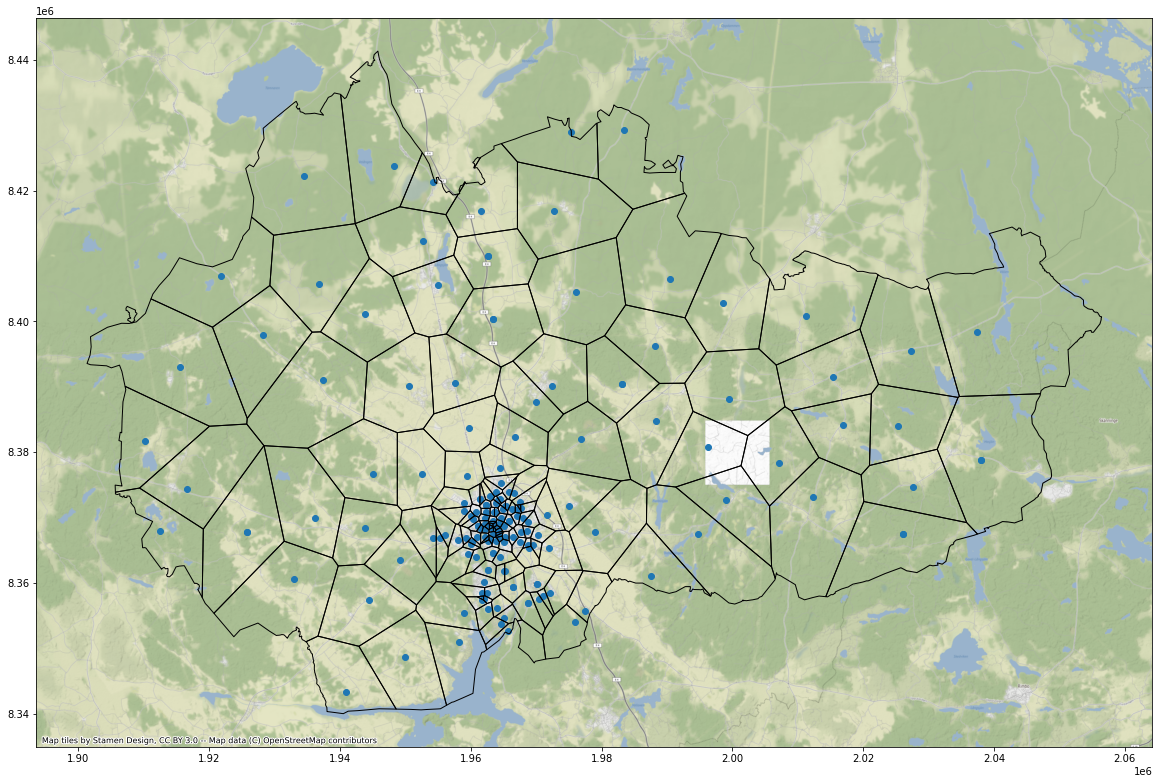

In [366]:
antennas_within, voronoi_polygons = get_vcs_for_bounding_area(antennas_gdp, uppsala_lan)


ax = antennas_within.to_crs(WGS84_EPSG).plot(figsize= (20,20))
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
ctx.add_basemap(ax=ax, zoom=12)

# reading the datasets

In [233]:
read_df = read_data(DATA_DIR)

371 data/result2017-11-20_2017-11-21.csv
70 data/result2018-05-16_2018-05-17.csv
path data/result2018-05-17_2018-05-16.csv is wrong. check it.
path data/result2018-05-19_2018-05-20.csv is wrong. check it.
315 data/result2018-05-21_2018-05-20.csv
316 data/result2018-05-23_2018-05-24.csv
275 data/result2018-07-03_2018-07-04.csv
240 data/result2018-07-05_2018-07-06.csv
path data/result2018-08-19.csv is wrong. check it.
128 data/result2018-10-03.csv
219 data/result2018-10-06_2018-10-05.csv
118 data/result2018-10-13.csv
99 data/result2018-10-19_2018-10-20.csv
131 data/result2018-10-26_2018-10-27.csv
path data/result2018-11-11.csv is wrong. check it.
95 data/result2019-02-09_2019-02-08.csv
path data/result2019-04-29.csv is wrong. check it.
51 data/result2019-05-23.csv
138 data/result2019-05-26.csv
27 data/result2019-06-12.csv
path data/result2019-06-13_2019-06-12.csv is wrong. check it.
89 data/result2019-06-22.csv
path data/result2019-08-18.csv is wrong. check it.
22 data/result2020-11-15.c

In [234]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         3017 non-null   datetime64[ns]
 1   geometry_gps_csv  3017 non-null   object        
 2   geometry_mpn_csv  3017 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 70.8+ KB


# looking into antennas.... Are there any antennas which are in use too often?

In [235]:
most_common_antennas  = collections.Counter(read_df['geometry_mpn_csv'] ).most_common(50)
# antennas[0].__str__()
print(most_common_antennas)
most_common_antennas_name = [p[0] for p in most_common_antennas]



[('[1962551.4902066502, 8368523.324821025]', 500), ('[1964210.1508783628, 8367570.084025911]', 306), ('[1960770.3787997721, 8363957.758319987]', 241), ('[1529930.5534558315, 8142099.3227781635]', 141), ('[1961493.9552144122, 8368434.645070898]', 98), ('[2088342.5148085796, 8331062.918022333]', 64), ('[1963920.7211401542, 8368368.136306725]', 58), ('[1958944.738900855, 8371095.468807294]', 50), ('[2024267.0160194887, 8438019.853887266]', 40), ('[1960915.09353762, 8367148.924061911]', 39), ('[1962072.8171324257, 8369897.980354814]', 30), ('[1465487.6997577657, 8073562.341234317]', 22), ('[2010296.420430603, 8252122.465912386]', 20), ('[1970232.5356793732, 8367237.588064031]', 18), ('[1539359.3154589143, 8133374.207890227]', 17), ('[1554932.9121099235, 8127448.6714701615]', 16), ('[1960013.406850959, 8370186.245993523]', 15), ('[1987520.4517509544, 8360989.439610706]', 15), ('[1981542.5951772819, 8343491.787029915]', 15), ('[1976065.6762251565, 8343823.215322355]', 15), ('[1978180.7472161

Text(0, 0.5, 'number of occurrancies')

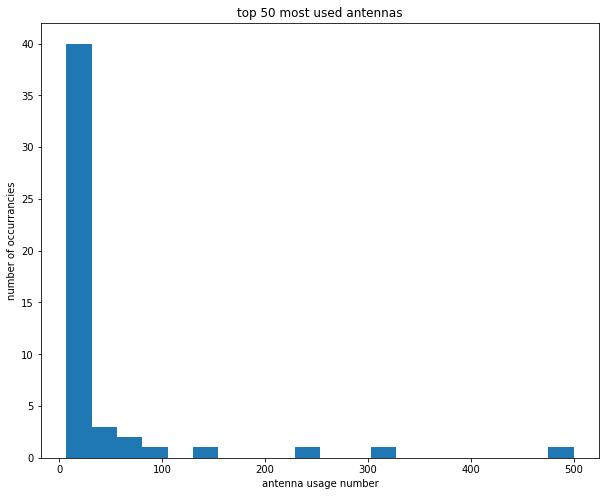

In [236]:
plt.figure(figsize=(10,8))
plt.hist([a[1] for a in most_common_antennas], bins=20)
plt.title('top 50 most used antennas')
plt.xlabel('antenna usage number')
plt.ylabel("number of occurrancies")

In [237]:
read_df = read_df[
    ~read_df['geometry_mpn_csv'].isin(most_common_antennas_name[:6])
]

In [238]:
read_df

timestamp                         geometry_gps_csv  \
101  2017-11-21 07:20:00  [1958963.5311100786, 8365630.054926272]   
105  2017-11-21 07:30:00  [1959414.3576980869, 8366200.606162449]   
106  2017-11-21 07:35:00    [1962123.1695793138, 8365965.8618547]   
107  2017-11-21 07:35:00    [1962123.1695793138, 8365965.8618547]   
108  2017-11-21 07:40:00  [1963252.9333469786, 8365429.572469718]   
...                  ...                                      ...   
3012 2021-04-11 15:45:00   [1342579.850661355, 7859114.468195349]   
3013 2021-04-11 15:45:00   [1342579.850661355, 7859114.468195349]   
3014 2021-04-11 15:45:00   [1342579.850661355, 7859114.468195349]   
3015 2021-04-11 15:50:00  [1347054.8941912448, 7856050.354761059]   
3016 2021-04-11 15:50:00  [1347054.8941912448, 7856050.354761059]   

                              geometry_mpn_csv  
101    [1959378.8861048683, 8366905.105530577]  
105      [1960915.09353762, 8367148.924061911]  
106      [1960915.09353762, 8367148.924061911]  
107    [1965045.0479561617, 8366284.512862332]  
108      [1960915.09353762, 8367148.924061911]  
...                                        ...  
3012  [1353021.6183124061, 7981005.4629582325]  
3013     [1353466.89715972, 7965322.147310695]  
3014   [1359121.9277262618, 7977428.638223978]  
3015     [1353466.89715972, 7965322.147310695]  
3016   [1353611.6131216942, 7973264.832892545]  

[1667 rows x 3 columns]

In [239]:
read_df  = process_df(read_df.copy())

In [240]:
read_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 805 entries, 2017-11-21 07:20:00 to 2021-04-11 15:50:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geometry_gps_csv  805 non-null    geometry
 1   geometry_mpn_csv  805 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 18.9+ KB


In [241]:
read_df

geometry_gps_csv  \
timestamp                                              
2017-11-21 07:20:00  POINT (1958963.531 8365630.055)   
2017-11-21 07:30:00  POINT (1959414.358 8366200.606)   
2017-11-21 07:35:00  POINT (1962123.170 8365965.862)   
2017-11-21 07:40:00  POINT (1963252.933 8365429.572)   
2017-11-21 07:45:00  POINT (1962691.519 8365549.336)   
...                                              ...   
2021-04-11 15:30:00  POINT (1336752.275 7899717.161)   
2021-04-11 15:35:00  POINT (1340910.058 7885916.219)   
2021-04-11 15:40:00  POINT (1341650.333 7871092.979)   
2021-04-11 15:45:00  POINT (1342579.851 7859114.468)   
2021-04-11 15:50:00  POINT (1347054.894 7856050.355)   

                                                                                                                                                                                        geometry_mpn_csv  
timestamp                                                                                                                                                                                                 
2017-11-21 07:20:00                                                                                                                                        [POINT (1959378.886104868 8366905.105530577)]  
2017-11-21 07:30:00                                                                                                                                         [POINT (1960915.09353762 8367148.924061911)]  
2017-11-21 07:35:00                                                                                            [POINT (1960915.09353762 8367148.924061911), POINT (1965045.047956162 8366284.512862332)]  
2017-11-21 07:40:00                                               [POINT (1960915.09353762 8367148.924061911), POINT (1965045.047956162 8366284.512862332), POINT (1962607.151280855 8362052.581460901)]  
2017-11-21 07:45:00                                                                                            [POINT (1960915.09353762 8367148.924061911), POINT (1963364.123428715 8364644.627571156)]  
...                                                                                                                                                                                                  ...  
2021-04-11 15:30:00                                                                                                                                         [POINT (1366981.083176742 8020526.84569566)]  
2021-04-11 15:35:00                                                                                             [POINT (1351362.95916608 8005605.39580591), POINT (1351359.247067726 8005605.395392721)]  
2021-04-11 15:40:00                                                                                             [POINT (1346231.1297336 7991830.468806214), POINT (1350795.228903738 7997480.827292535)]  
2021-04-11 15:45:00  [POINT (1353611.613121694 7973264.832892545), POINT (1353021.618312406 7981005.462958232), POINT (1353466.89715972 7965322.147310695), POINT (1359121.927726262 7977428.638223978)]  
2021-04-11 15:50:00                                                                                            [POINT (1353466.89715972 7965322.147310695), POINT (1353611.613121694 7973264.832892545)]  

[805 rows x 2 columns]

In [242]:
read_df['geometry_mpn_csv'].iloc[0][0].__str__()

# read_df['geometry_mpn_csv'] = read_df.apply(lambda row: [point for point   in row.geometry_mpn_csv if point != top_antenna.geometry], axis=1)
# read_df.apply(lambda row: [point for point   in row.geometry_mpn_csv if point.__str__() in top_antenna_str[:1]], axis=1).values



'POINT (1959378.886104868 8366905.105530577)'

In [243]:
# read_df = get_objects_within_area(read_df.copy(), uppsala_lan.to_crs(WGS84_EPSG), geom='geometry_gps_csv')
read_df = get_objects_within_area(read_df.copy(), sweden.to_crs(WGS84_EPSG), geom='geometry_gps_csv')


read_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             805 non-null    datetime64[ns]
 1   geometry_gps_csv  805 non-null    geometry      
 2   geometry_mpn_csv  805 non-null    object        
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 19.0+ KB


KeyboardInterrupt: 

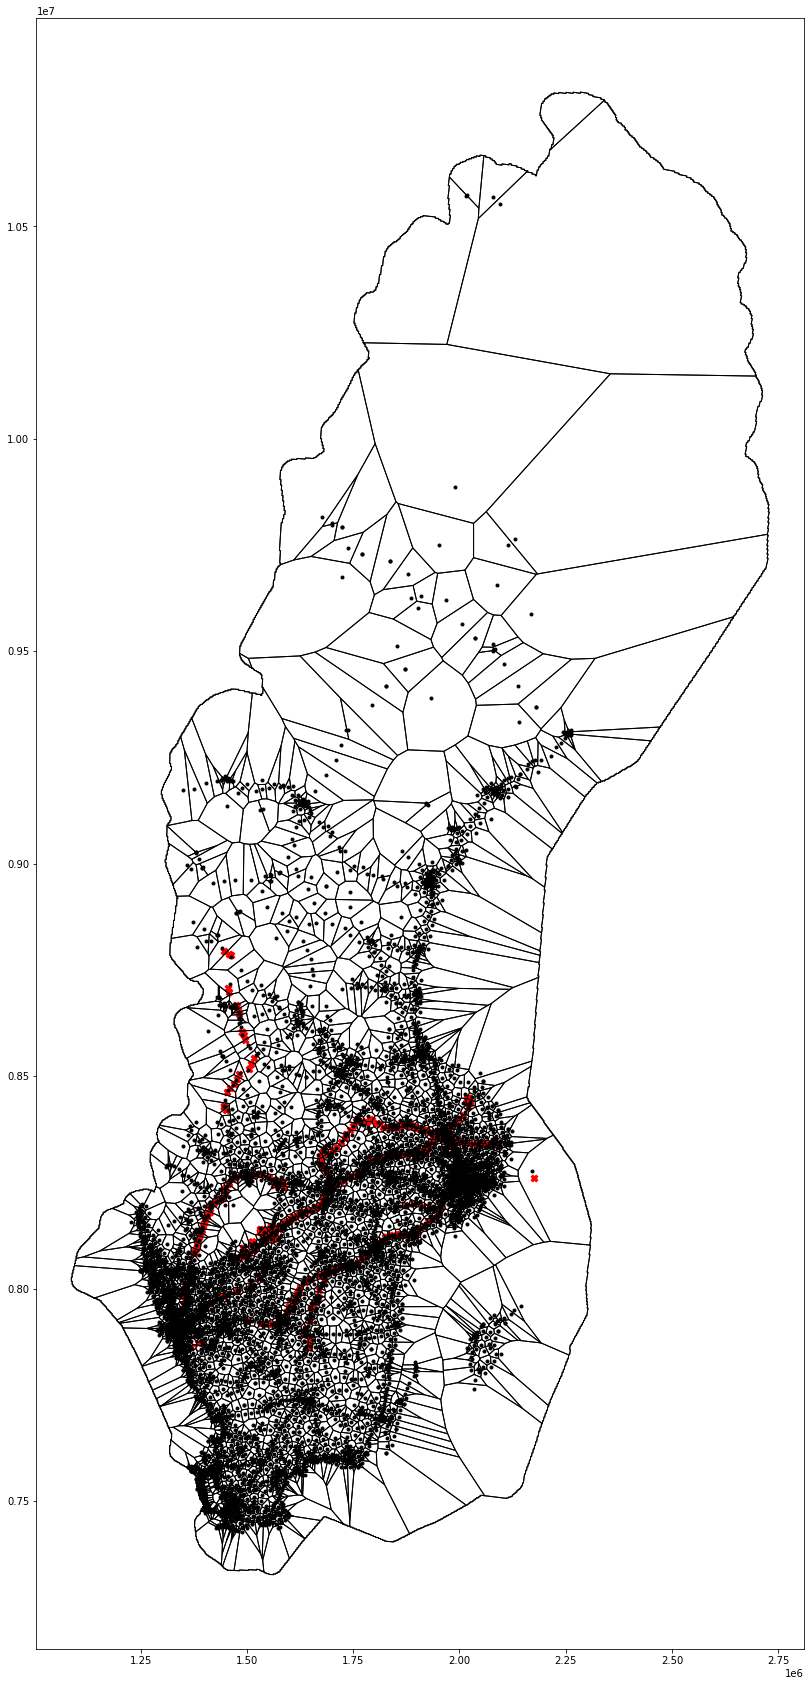

In [39]:
ax = sweden.to_crs(WGS84_EPSG).plot(figsize= (30,30),  facecolor='none', label = "Sweden border")
read_df.plot(ax=ax, label= "tracks'  points" , marker='X', markersize=45, color='red')
voronoi_polygons.to_crs(WGS84_EPSG).plot(ax=ax,  facecolor='none')
antennas_within.to_crs(WGS84_EPSG).plot(ax=ax, label = 'antennas', marker='.', color='black')
ctx.add_basemap(ax=ax, zoom=10)
plt.title('Part  of the track within the borders of Sweden, Sweden')
plt.legend()
plt.savefig('../docs/pics/track_within_shape.png', bbox_inches = "tight")

In [244]:
%time read_df = add_vcs_indexes(read_df.copy(), voronoi_polygons.to_crs(WGS84_EPSG))
# read_df

CPU times: user 1min 14s, sys: 335 ms, total: 1min 14s
Wall time: 1min 14s


In [245]:
# read_df[:50]

In [246]:
get_rings_around_cell(119, voronoi_polygons.to_crs(WGS84_EPSG), 2)

[[119], [120, 121, 122, 123, 238], [70, 239, 241, 404, 405]]

In [247]:
tmp = voronoi_polygons.to_crs(WGS84_EPSG)

%time read_df[ 'vc_gps_rings'] = read_df.apply(lambda row:  get_rings_around_cell(row['vc_index_gps'], tmp, 6), axis=1)

CPU times: user 6min 17s, sys: 4.28 s, total: 6min 21s
Wall time: 6min 23s


In [248]:
mpn = read_df.iloc[4]['vc_index_mpn']
rings = read_df.iloc[4]['vc_gps_rings']
make_hist_mpn_geoms(mpn, rings)

[1, 1]

In [249]:
%time read_df[ 'hist'] = read_df.apply(lambda row:  make_hist_mpn_geoms(row['vc_index_mpn'], row['vc_gps_rings']), axis=1)

CPU times: user 27.3 ms, sys: 2.29 ms, total: 29.6 ms
Wall time: 28.6 ms


In [250]:
[read_df.iloc[0]['geometry_gps_csv'].distance(item) 
 for item in read_df.iloc[0].geometry_mpn_csv]



[1340.997321114357]

In [251]:
%time read_df[ 'distances'] = read_df.apply(lambda row:  [row['geometry_gps_csv'].distance(item)/1000\
                                                          for item in row['geometry_mpn_csv']], axis=1)

CPU times: user 31.3 ms, sys: 2.98 ms, total: 34.3 ms
Wall time: 32 ms


In [252]:
# read_df[read_df['vc_index_mpn'].apply(lambda row: len(row)>1 )]

In [497]:
def _plot_ring_hist(data, bins=None, density=True):
    """
    plotting histogram for rings
    """

    hst = [el for sublist in data.to_list() for el in sublist]
#     print(hst)
    if bins:
        his = np.histogram(hst,bins=bins)
    else:
        his = np.histogram(hst,bins=range(max(hst)+2), density=density)
    
    plt.figure(figsize=(15,10))
    plt.xlabel('ring number')
    plt.ylabel('number of occurences')
    plt.title("""Voronoi cell ring histogram for a GPS position
    averaged over 5 minute intervals. Number of MPN positions is %i,  number of timestamps is %i."""%
              (len(hst), read_df.shape[0]))
    plt.bar(his[1][:-1], his[0], width=0.8*(his[1][1]-his[1][0]))


    plt.savefig('../docs/pics/hist_ring.png', bbox_inches = "tight")


In [255]:
def _plot_dist_hist(data, bins=None):
    """
    plotting histogram for rings
    """

    hst = [el for sublist in data.to_list() for el in sublist]
#     print(hst)
    if bins:
        bns = np.arange(0, bins, .5)
        his = np.histogram(hst,bins= bns)
    else:
        his = np.histogram(hst,bins=range(max(hst)+2))
    plt.figure(figsize=(15,10))
    plt.xlabel('distance between GPS and MPN points, km')
    plt.ylabel('number of occurences')
    plt.title("""Voronoi cell distance histogram for a GPS position
    averaged over 5 minute intervals. Number of MPN positions is %i,  number of timestamps is %i"""%
              (len(hst), read_df.shape[0]))
    plt.xticks(bns, bns+.5,rotation=90)

   
    plt.bar(his[1][:-1], his[0], width=0.8*(his[1][1]-his[1][0]))


    plt.savefig('../docs/pics/hist_dist.png', bbox_inches = "tight")

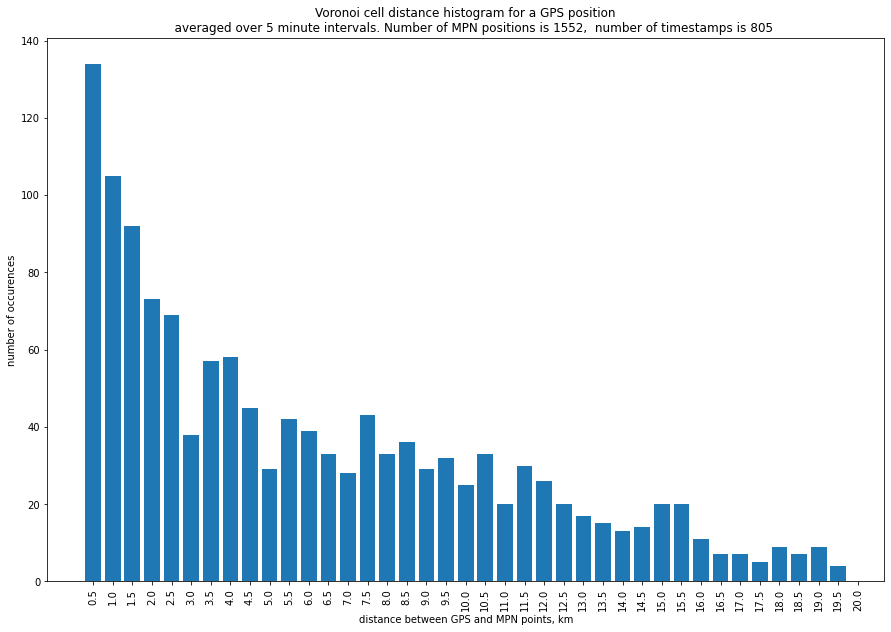

In [256]:
_plot_dist_hist(read_df['distances'], bins=20)

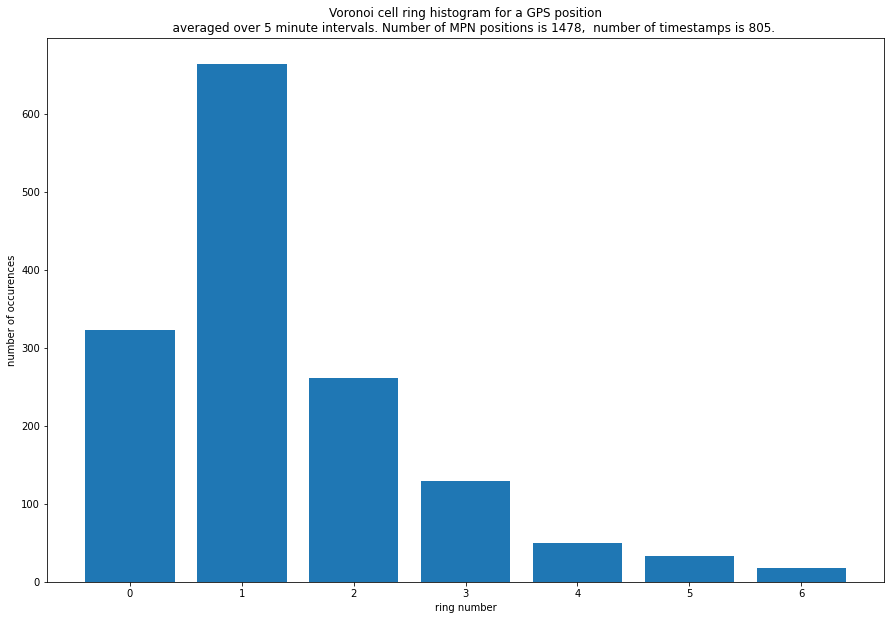

In [257]:
_plot_ring_hist(read_df['hist'])

# looking into VCs for the tracks

In [286]:
unique_vc_indexes_tracks = np.unique(read_df[['vc_index_gps', 'vc_index_mpn']].explode('vc_index_mpn').values.flatten())
unique_vc_indexes_tracks[:5], unique_vc_indexes_tracks.shape

(array([77, 81, 82, 164, 198], dtype=object), (656,))

In [288]:
vc_used = voronoi_polygons.iloc[unique_vc_indexes_tracks]
vc_used.shape[0] == unique_vc_indexes_tracks.shape[0]

True

Text(0.5, 1.0, 'Visited Voronoi cells and their sizes')

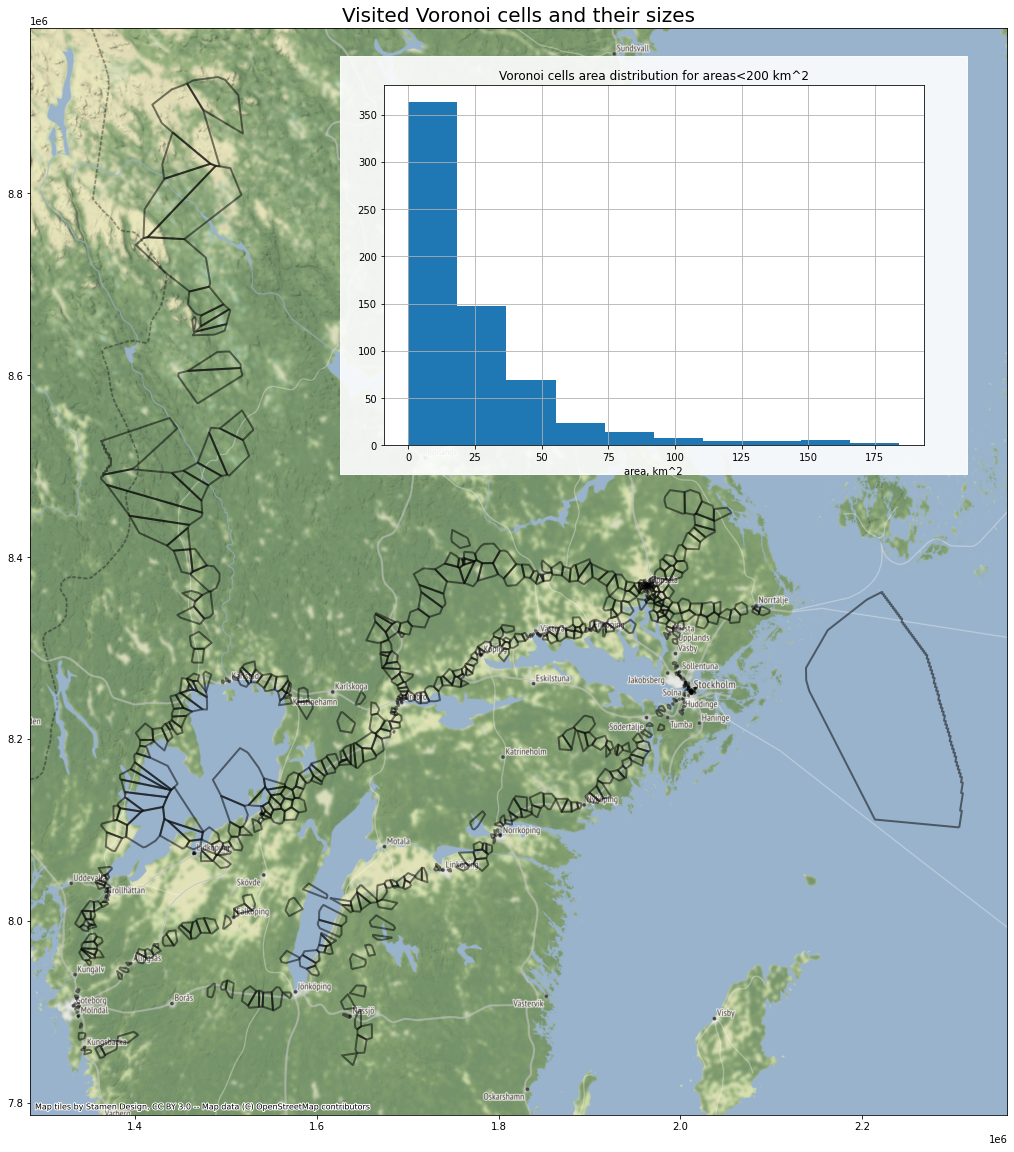

In [386]:
# https://stackoverflow.com/questions/21001088/how-to-add-different-graphs-as-an-inset-in-another-python-graph
# https://stackoverflow.com/questions/21535294/matplotlib-add-rectangle-to-figure-not-to-axes


fig, ax1 = plt.subplots(figsize = (30,20),)

left, bottom, width, height = [0.45, 0.59, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height],zorder=30)

fig.patches.extend([plt.Rectangle((left-0.02,bottom-0.02),width+0.04,height+0.04,
                                  fill=True, color='w', alpha=0.9, zorder=20,
                                  transform=fig.transFigure, figure=fig)])


vc_used.to_crs(WGS84_EPSG).plot(ax=ax1, alpha=0.5, linewidth=2, facecolor='none')
ctx.add_basemap(ax=ax1)


# plt.setp(ax2.get_xticklabels(), backgroundcolor="limegreen")
# plt.setp(ax2.get_yticklabels(), backgroundcolor="limegreen")


# ax2.set_facecolor('xkcd:salmon')
# ax3 = fig.add_axes([left-.01, bottom+.01, width, height])




# vc_used.crs


area = vc_used.geometry.area/10**6
area_max = 200
area = area[area<area_max]
area.hist().plot( ax=ax2)
ax2.set_title("Voronoi cells area distribution for areas<%s km^2"%area_max)
ax2.set_xlabel("area, km^2")
ax1.set_title("Visited Voronoi cells and their sizes", fontsize=20)


# calculating size borders for VC size splits

In [527]:
splits = np.array_split(area.sort_values().round(2), 3)
size_borders = [(el.iloc[0], el.iloc[-1])   for el in splits]
size_borders

[(0.01, 2.63), (2.71, 24.67), (25.16, 184.09)]

In [396]:
read_df

index                 geometry_gps_csv  \
0   2017-11-21 07:20:00  POINT (1958963.531 8365630.055)   
1   2017-11-21 07:30:00  POINT (1959414.358 8366200.606)   
2   2017-11-21 07:35:00  POINT (1962123.170 8365965.862)   
3   2017-11-21 07:40:00  POINT (1963252.933 8365429.572)   
4   2017-11-21 07:45:00  POINT (1962691.519 8365549.336)   
..                  ...                              ...   
800 2021-04-11 15:30:00  POINT (1336752.275 7899717.161)   
801 2021-04-11 15:35:00  POINT (1340910.058 7885916.219)   
802 2021-04-11 15:40:00  POINT (1341650.333 7871092.979)   
803 2021-04-11 15:45:00  POINT (1342579.851 7859114.468)   
804 2021-04-11 15:50:00  POINT (1347054.894 7856050.355)   

                                                                                                                                                                        geometry_mpn_csv  \
0                                                                                                                                          [POINT (1959378.886104868 8366905.105530577)]   
1                                                                                                                                           [POINT (1960915.09353762 8367148.924061911)]   
2                                                                                              [POINT (1960915.09353762 8367148.924061911), POINT (1965045.047956162 8366284.512862332)]   
3                                                 [POINT (1960915.09353762 8367148.924061911), POINT (1965045.047956162 8366284.512862332), POINT (1962607.151280855 8362052.581460901)]   
4                                                                                              [POINT (1960915.09353762 8367148.924061911), POINT (1963364.123428715 8364644.627571156)]   
..                                                                                                                                                                                   ...   
800                                                                                                                                         [POINT (1366981.083176742 8020526.84569566)]   
801                                                                                             [POINT (1351362.95916608 8005605.39580591), POINT (1351359.247067726 8005605.395392721)]   
802                                                                                             [POINT (1346231.1297336 7991830.468806214), POINT (1350795.228903738 7997480.827292535)]   
803  [POINT (1353611.613121694 7973264.832892545), POINT (1353021.618312406 7981005.462958232), POINT (1353466.89715972 7965322.147310695), POINT (1359121.927726262 7977428.638223978)]   
804                                                                                            [POINT (1353466.89715972 7965322.147310695), POINT (1353611.613121694 7973264.832892545)]   

     vc_index_gps              vc_index_mpn  \
0            4207                    [4219]   
1            4207                    [4760]   
2            4917              [4760, 6647]   
3            5583        [4760, 6647, 4211]   
4            4917              [4760, 5583]   
..            ...                       ...   
800          6373                    [5990]   
801          7420              [4750, 3291]   
802          6475              [4042, 4749]   
803          5406  [2512, 3295, 3250, 2449]   
804          5982              [3250, 2512]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# indexes of VCs

In [427]:
vc_idxs  =  [el for el in read_df.iloc[3]['vc_index_mpn']]
vc_idxs

[4760, 6647, 4211]

# get areas for VCs

In [423]:
areas = voronoi_polygons.iloc[vc_idxs].geometry.area/10**6
areas.values

array([0.53609   , 0.74133042, 1.53693348])

# create list of Bools for each element in `vc_index_mpn`

In [424]:
[(el < size_borders[0][1]) & (el>size_borders[0][0]) for el in areas]

[True, True, True]

In [435]:
size_borders_lst= []
for size_ in size_borders:
    group = []
    for row in read_df['vc_index_mpn']:
        vc_idxs  =  [el for el in row]
        areas = voronoi_polygons.iloc[vc_idxs].geometry.area/10**6
        group.append([(el < size_[1]) & (el>size_[0]) for el in areas])

    size_borders_lst.append(group)
    

In [438]:
for key, val in enumerate(size_borders_lst):
    read_df['group'+str(key)] = val

In [475]:
read_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             805 non-null    datetime64[ns]
 1   geometry_gps_csv  805 non-null    geometry      
 2   geometry_mpn_csv  805 non-null    object        
 3   vc_index_gps      805 non-null    int64         
 4   vc_index_mpn      805 non-null    object        
 5   vc_gps_rings      805 non-null    object        
 6   hist              805 non-null    object        
 7   distances         805 non-null    object        
 8   group0            805 non-null    object        
 9   group1            805 non-null    object        
 10  group2            805 non-null    object        
dtypes: datetime64[ns](1), geometry(1), int64(1), object(8)
memory usage: 69.3+ KB


In [502]:
for key in range(len(size_borders_lst)):

    read_df['hist'+str(key)] = read_df[['hist', 'group'+str(key)]].apply(
        lambda row:   [el[0] for el in zip(row['hist'],row['group'+str(key)])  if el[1]==True], 
        axis=1)

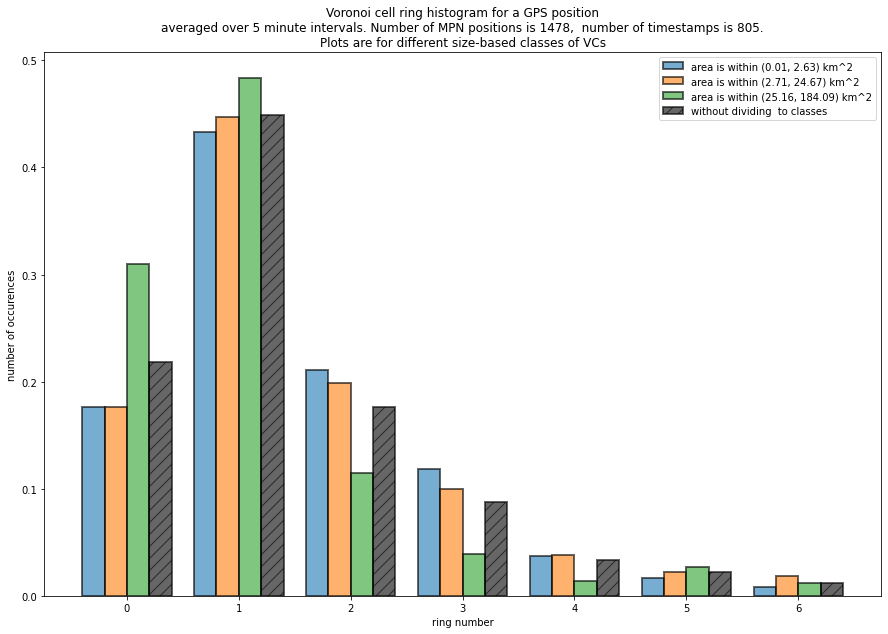

In [560]:
plt.figure(figsize=(15,10))
plt.xlabel('ring number')
plt.ylabel('number of occurences')
plt.title("""Voronoi cell ring histogram for a GPS position
averaged over 5 minute intervals. Number of MPN positions is %i,  number of timestamps is %i.
Plots are for different size-based classes of VCs"""%
              (len(hst), read_df.shape[0]))
    
for key in range(len(size_borders_lst)):
    hst = [el for sublist in read_df['hist'+str(key)].to_list() for el in sublist]
#     print(hst)

    his = np.histogram(hst,bins=range(max(hst)+2), density=True)
    
  
    plt.bar(his[1][:-1]+0.2*(key-1.5), his[0], width=0.2*(his[1][1]-his[1][0]), 
            label="area is within "+ str(size_borders[key])+ ' km^2', 
            linewidth=2, alpha=0.6,edgecolor='black'
)

hst = [el for sublist in read_df['hist'].to_list() for el in sublist]
his = np.histogram(hst,bins=range(max(hst)+2), density=True)
plt.bar(his[1][:-1]+0.2*(key-.5), his[0], width=0.2*(his[1][1]-his[1][0]), 
            label='without dividing  to classes', 
            linewidth=2, alpha=0.6,edgecolor='black', facecolor='black',hatch=r"//"
)
plt.legend()



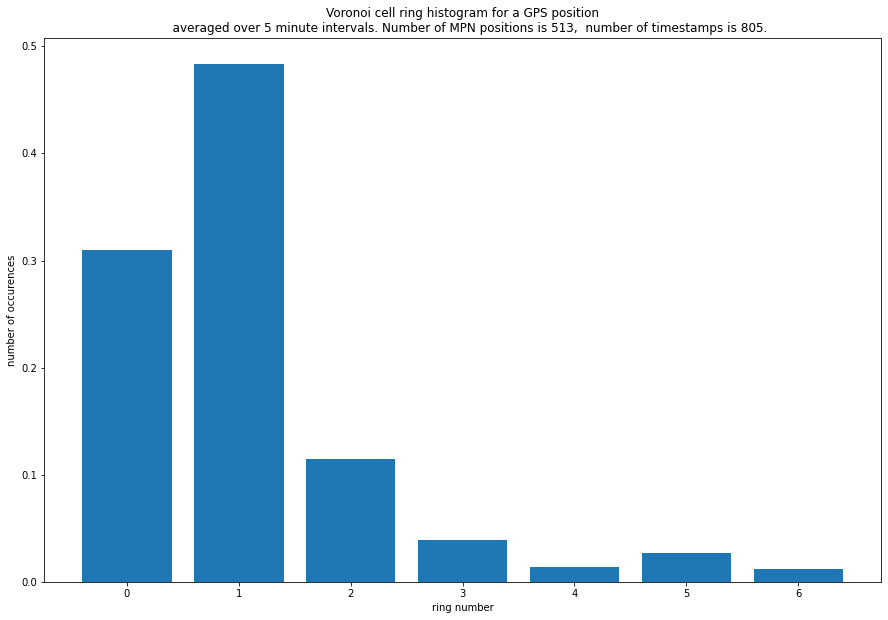

In [500]:
_plot_ring_hist(read_df['hist2'], density=True)



In [202]:
# _plot_ring_hist(read_df['hist'].sample(50))#.index[0] #reset_index()
series_diffs = []
series_length = 10
for serie in range(series_length):
    hist_vals = []
    sample_size = [10,  50, 100,200, 300, 500, len(read_df['hist'])]
    for sample in sample_size:
        data = read_df['hist'].sample(sample)
        hst = [el for sublist in data.to_list() for el in sublist]
        his = np.histogram(hst,bins=range(7), density=True)
        hist_vals.append(his[0])


    diffs = [sum(abs(element - hist_vals[-1])) for element in hist_vals]
    series_diffs.append(diffs)
series_diffs
# plt.plot(series_diffs, marker='x')

series_diffs_pd = pd.DataFrame(series_diffs,columns=sample_size)
# series_diffs_pd

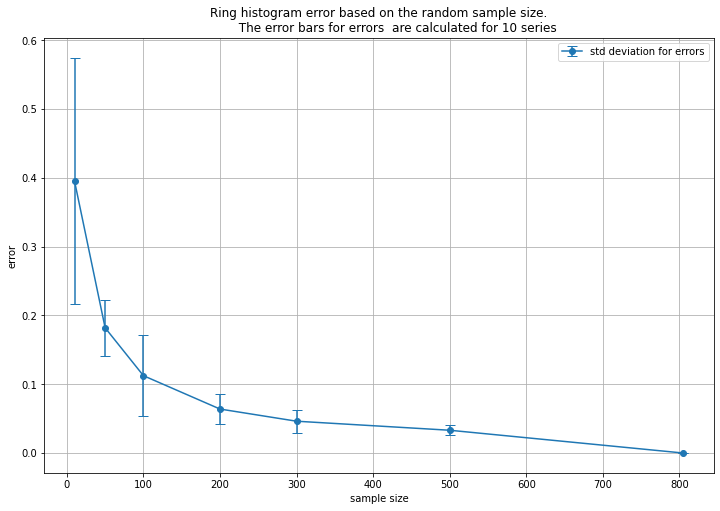

In [203]:
means = series_diffs_pd.describe().loc['mean']
std = series_diffs_pd.describe().loc['std']

means.plot(yerr=std, marker='o', capsize=5, figsize=(12,8), label='std deviation for errors')
plt.xlabel('sample size')
plt.ylabel('error')
plt.title("""Ring histogram error based on the random sample size.
          The error bars for errors  are calculated for %i series"""%(series_length))
plt.legend()
plt.grid()

In [92]:
len(collections.Counter(antennas).keys()), sum(collections.Counter(antennas).values())

(347, 1368)

In [93]:
import re

re.search('\(.*?\)', 'POINT (1960770.378799772 8363957.758319987)').group(0)[1:-1].split(' ')[0]

'1960770.378799772'

In [98]:
# voronoi_polygons.to_crs(WGS84_EPSG)
most_common_antennas[0]

('[1960770.3787997721, 8363957.758319987]', 306)

In [101]:
x = [re.search('\[.*?\]', point[0]).group(0)[1:-1].split(',')[0]  for point in most_common_antennas]
y = [re.search('\[.*?\]', point[0]).group(0)[1:-1].split(',')[1]  for point in most_common_antennas]

# x = [point[0][1:-1].split(' ')[0]  for point in most_common_antennas]
# y = [point[0][1:-1].split(' ')[1]  for point in most_common_antennas]

x = [float(el) for el in x]
y = [float(el) for el in y]


top_antenna = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x,y) , crs=WGS84_EPSG)
top_antenna
# tmp1 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(tmp.envelope))
# inter = gpd.overlay(voronoi_polygons, tmp1)
# inter.plot()

geometry
0  POINT (1960770.379 8363957.758)
1  POINT (1961493.955 8368434.645)
2  POINT (2088342.515 8331062.918)
3  POINT (1960915.094 8367148.924)
4  POINT (1962551.490 8368523.325)
5  POINT (1465487.700 8073562.341)
6  POINT (1963920.721 8368368.136)
7  POINT (1960013.407 8370186.246)
8  POINT (1965835.416 8369565.378)
9  POINT (1692401.351 8042222.183)

In [102]:
# within = [p for _, p in voronoi_polygons.iterrows() if p.within(tmp.geometry)]
# within
polys =[]
# voronoi_polygons[voronoi_polygons.to_crs(WGS84_EPSG).geometry.contains(tmp.geometry)]
for _, poly in voronoi_polygons.to_crs(WGS84_EPSG).iterrows():
    for _, p in top_antenna.iterrows():
        if p.geometry.within(poly.geometry):
            polys.append(poly.geometry)

In [103]:
vor_pol = gpd.GeoDataFrame(geometry=polys)

Text(0.5, 1.0, 'out of about 1000 antennas this one occured about 100 times')

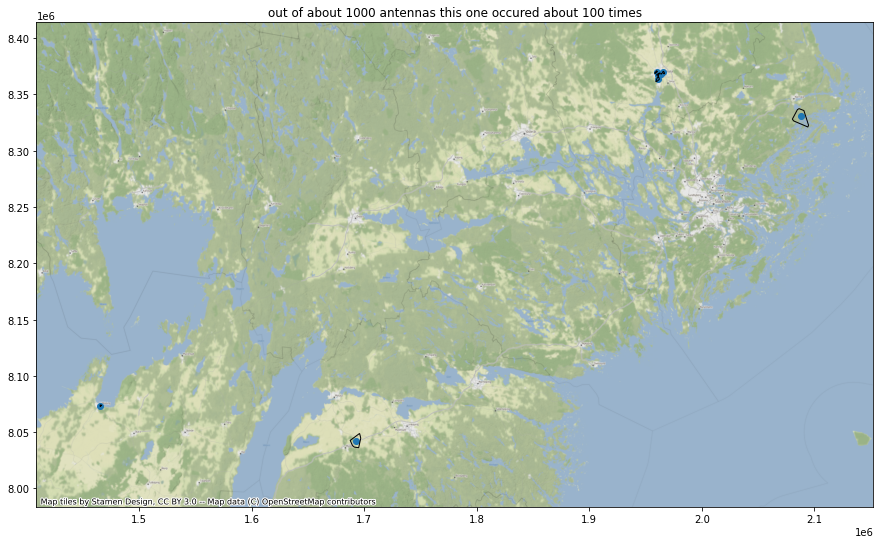

In [105]:
ax = top_antenna.plot(figsize=(15,15))
vor_pol.plot(ax=ax, facecolor='none')
ctx.add_basemap(ax=ax, zoom=10, reset_extent=False)
plt.title('out of about 1000 antennas this one occured about 100 times')

In [314]:
areas = voronoi_polygons['geometry'].area/10**6

In [315]:
areas

0      105.571455
1       47.692901
2       64.722667
3       22.635160
4       31.188548
          ...    
164      0.416997
165      0.063205
166      2.159153
167      0.746963
168      0.202243
Length: 169, dtype: float64

Text(0, 0.5, 'number of occurencies')

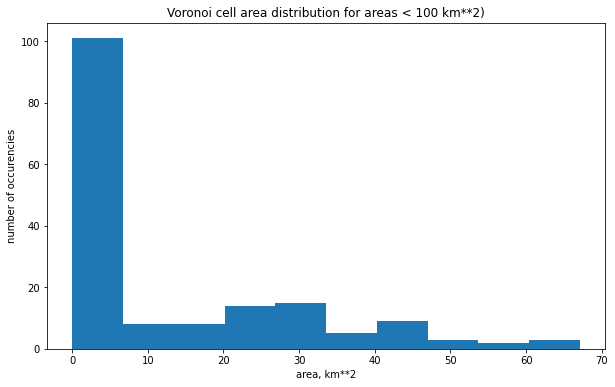

In [316]:
plt.figure(figsize=(10,6))

max_area = 100
plt.hist(areas[areas.values < max_area])
plt.title("Voronoi cell area distribution for areas < %i km**2)"%max_area)
plt.xlabel('area, km**2')
plt.ylabel('number of occurencies')


In [52]:
linear_size_vc_uppsala = np.sqrt(voronoi_polygons['geometry'].area/10**6)
max_size = 20
linear_size_vc_uppsala = linear_size_vc_uppsala[linear_size_vc_uppsala < max_size]



In [53]:
linear_size_vc_uppsala

6       17.548426
10      14.596965
16      16.372142
18      15.702471
19       7.230676
          ...    
8346     0.187487
8347     0.280447
8348     0.288122
8349     0.235304
8350     0.182843
Length: 8130, dtype: float64

In [54]:
linear_size_vc_uppsala.describe()

count    8130.000000
mean        3.911909
std         3.631477
min         0.084694
25%         0.897952
50%         2.883184
75%         6.010769
max        19.959153
dtype: float64

Text(0.5, 1.0, 'linear size VC histogram for Uppsala')

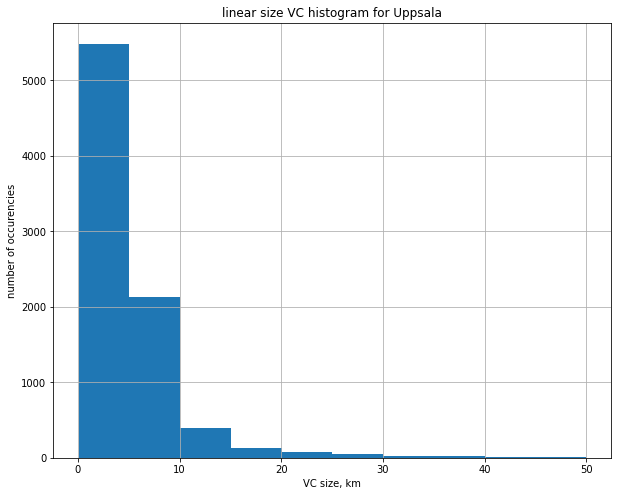

In [51]:
plt.figure(figsize=(10,8))


linear_size_vc_uppsala.hist()
plt.xlabel('VC size, km')
plt.ylabel('number of occurencies')
plt.title('linear size VC histogram for Uppsala')

#  полигоны Вороного, которые "вовлечены" в траекторию

<AxesSubplot:>

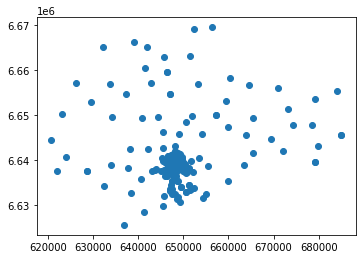

In [324]:
antennas_within.plot()